## ==================== Libraries ====================

In [1]:
# Determinadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# Procesamiento de imágenes
import cv2

In [2]:
# Algoritmo de evolución diferencial propio.
from differential_evolution import differential_algorithm

## <br><br><br><br>====================  Functions ====================

In [3]:
def orderPoints(points):
    ''' Regresa las coordenadas de los vértices de un polígono de 4 lados en el 
        orden: Arriba-Izquierda, Arriba-Derecha, Abajo-Derecha, Abajo-Izquierda.
        points: Coordenadas de los vértices de un polígono de 4 lados. '''
    
    # Puntos ordenados.
    ordered_points = np.zeros((4, 2), dtype = "float32")
    
    # Orden para saber cuáles son los puntos de arriba y de abajo del rectángulo.
    sort = np.argsort(points[:,1])
    top_sort = points[sort[:2]]
    bottom_sort = points[sort[2:]]
    
    # Arriba-Izquierda.
    ordered_points[0] = top_sort[np.argmin(top_sort[:,0])]
    # Arriba-Derecha
    ordered_points[1] = top_sort[np.argmax(top_sort[:,0])]
    # Abajo-Derecha
    ordered_points[2] = bottom_sort[np.argmax(bottom_sort[:,0])]
    # Abajo-Izquierda.
    ordered_points[3] = bottom_sort[np.argmin(bottom_sort[:,0])]

    return ordered_points

In [4]:
def rectangleImageTransform(img, points):
    ''' Regresa una imagen deformada según los contornos de un polígono de 4
        lados.
        img: Imagen.
        points: Coordenadas de los vértices de un polígono de 4 lados. '''
    
    # Obtener puntos ordenados del rectángulo.
    rect = orderPoints(points)
    
    # Desempaquetar puntos del rectángulo.
    tl, tr, br, bl = rect

    # Calcular el ancho de la nueva imagen (distancia entre coordenadas).
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Calcular la altura de la nueva imagen (distancia entre coordenadas).
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Dimensiones de la nueva imagen.
    new_img_dimension = np.array([[0, 0],
                                  [maxWidth - 1, 0],
                                  [maxWidth - 1, maxHeight - 1],
                                  [0, maxHeight - 1]], dtype = "float32")

    # Realizar la transformación.
    M = cv2.getPerspectiveTransform(rect, new_img_dimension)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    # Redimensionar imagen.
    warped = cv2.resize(warped, (800, 500))
    
    return warped

In [5]:
def cutMatrix(img):
    ''' Regresa una imagen de la matriz de colores recortada.
        img: Imagen. '''
    
    # Copiar imagen.
    img_copy = img.copy()
    
    # Sacar forma de la imagen.
    height, width, channels = img.shape
    
    # Obtener área de la imagen.
    img_area = height*width

    # Convertir a escala de grises.
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Obtener bordes.
    thresh = cv2.threshold(img_gray, 160, 200, cv2.THRESH_BINARY_INV)[1]
    
    # Obtener contornos.
    countours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # El mejor candidato.
    best_fig = []
    best_fig_area = 0
    
    # Restringir los rectángulos válidos
    for c in countours:
        # Obtener su área.
        area = cv2.contourArea(c)
        
        # Calcular perímetro del contorno.
        epsilon = 0.018*cv2.arcLength(c,True)
        
        # Encontrar figura aproximada.
        approx_fig = cv2.approxPolyDP(c,epsilon,True)
        
        if len(approx_fig) == 4 and area >= img_area*0.01:  
            if area > best_fig_area:
                best_fig = approx_fig
                best_fig_area = area
    
    # Convertir a np.array.
    best_fig = np.array(best_fig[:,0,:])
    
    warped_img = rectangleImageTransform(img_copy, best_fig)
    
#     # Mostrar imagen.
#     plt.figure()
#     plt.plot(best_fig[0,0], best_fig[0,1], marker='v', color="red")
#     plt.plot(best_fig[1,0], best_fig[1,1], marker='v', color="red")
#     plt.plot(best_fig[2,0], best_fig[2,1], marker='v', color="red")
#     plt.plot(best_fig[3,0], best_fig[3,1], marker='v', color="red")
#     plt.imshow(img_copy, cmap="gray")
#     plt.title("Original color checker image")
#     plt.show()
    
    return warped_img

In [6]:
def getMatrix(img, matrix_shape, width_shape=10, height_shape=10):  
    ''' Regresa una matriz con los colores que hay en la imagen con la matriz de colores.
        img: Imagen.
        matrix_shape: Dimensiones de la matriz.
        width_shape: Ancho de la selección de color.
        height_shape: Altura de la selección de color. '''
    
    # Matriz.
    m = np.zeros((matrix_shape[0]*matrix_shape[1],3), dtype='uint8')
    
    # Imagen para visualizar dónde se tomaron los colores.
    color_extraction_img = img.copy()
    
    # Iterador para la matriz.
    m_it = 0
    
    # Coordenadas de inicio.
    x, y = 50, 50
    
    for i in range(matrix_shape[0]):        
        # Aumentar en 'y'.
        yi = y + i*130
        for j in range(matrix_shape[1]):
            # Aumentar en 'x'.
            xi = x + j*135
            
            # Extraer región de color.
            color_region = img[yi: yi + height_shape, xi: xi + width_shape]

            # Obtener la mediana de la región del color.
            color_median = np.array([np.median(color_region[:,:,0]), np.median(color_region[:,:,1]), np.median(color_region[:,:,2])])
    
            # Poner en la matriz.
            m[m_it] = color_median
        
            # Marcar región del color extraído con negro.
            color_extraction_img[yi: yi + height_shape, xi: xi + width_shape] = 0
            
            # Aumentar iterador.
            m_it += 1
    
#     # Mostrar imagen.
#     plt.figure(figsize=(7,7))
#     plt.imshow(color_extraction_img, cmap="gray")
#     plt.show()
    
    return m

## <br><br><br><br>====================  Main ====================

### Load color checker image (control matrix)

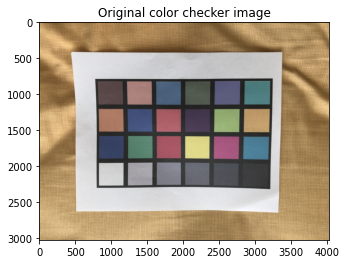

In [7]:
# Direcciones del dataset.
path = r'datasets/control_color_checker.jpg'

# Leer documento .csv.
control_color_checker_img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# Imagen a numpy array.
control_color_checker_img = np.asarray(control_color_checker_img)

# Mostrar imagen.
plt.figure()
plt.imshow(control_color_checker_img)
plt.title("Original color checker image")
plt.show()

### Load image to calibrate

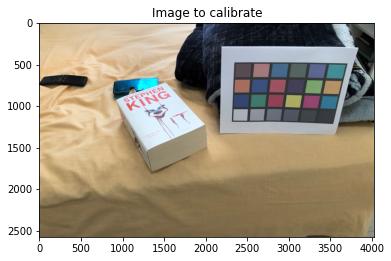

In [8]:
# Direcciones del dataset.
path = r'datasets/img_2.jpeg'

# Leer documento .csv.
image_to_calibrate = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# Imagen a numpy array.
image_to_calibrate = np.asarray(image_to_calibrate)

# Mostrar imagen.
plt.figure()
plt.imshow(image_to_calibrate)
plt.title("Image to calibrate")
plt.show()

### Cut matrices from the images

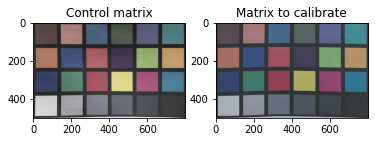

In [9]:
# Recortar matriz de control.
control_matrix_img = cutMatrix(control_color_checker_img)

# Recortar matriz a calibrar.
matrix_to_calibrate = cutMatrix(image_to_calibrate)

# Mostrar imagen.
plt.figure()
plt.subplot(1,2,1)
plt.imshow(control_matrix_img)
plt.title("Control matrix")
plt.subplot(1,2,2)
plt.imshow(matrix_to_calibrate)
plt.title("Matrix to calibrate")
plt.show()

### Get matrices

In [10]:
# Dimensiones de la matriz (4x6).
matrix_shape = [4,6]

# Obtener matriz de control
c = getMatrix(control_matrix_img, matrix_shape)

# Obtener matriz a calibrar.
mo = getMatrix(matrix_to_calibrate, matrix_shape)

# Impresión de las matrices.
print('c = \n', c, '\n\n')
print('Mo = \n', mo, '\n\n')

c = 
 [[ 89  71  71]
 [169 128 122]
 [ 73  94 121]
 [ 80  88  77]
 [ 90  91 123]
 [ 76 123 124]
 [172 122  99]
 [ 67  81 124]
 [171  94 101]
 [ 69  57  79]
 [149 174 116]
 [193 156 107]
 [ 54  65  97]
 [ 87 129 109]
 [169  87 101]
 [225 218 138]
 [168  88 127]
 [ 78 130 154]
 [214 214 214]
 [164 162 168]
 [126 126 138]
 [105 108 117]
 [ 82  83  90]
 [ 60  60  62]] 


Mo = 
 [[ 88  75  82]
 [163 121 123]
 [ 72 106 141]
 [ 85 100  97]
 [ 96 104 147]
 [ 67 140 149]
 [166 110  97]
 [ 58  80 127]
 [158  82  95]
 [ 69  64  87]
 [120 163 110]
 [180 146 101]
 [ 52  69 111]
 [ 63 121 107]
 [144  65  84]
 [170 170  97]
 [148  71 115]
 [ 52 118 148]
 [168 175 183]
 [140 144 155]
 [104 110 122]
 [ 78  83  93]
 [ 62  69  75]
 [ 55  59  63]] 




In [11]:
# De aquí para abajo haces lo que te toca. C y Mo son las matrices a
# utilizar. Y la imagen a calibrar se llama 'image_to_calibrate'.
# Calcular la matriz calibrada (Mc), ve la imagen que mandó Juan Pablo.